In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot, get_max_H_dist, plot_opt, get_conditional_mode
import tensorflow as tf
from neural_circuits.SC_Circuit_4 import SC_acc, SC_acc_diff, SC_acc_opto, \
                             SC_acc_var, SC_sim, \
                             SC_sim_opto, unwrap, \
                             get_schur_eigs, z_to_W, \
                            z_from_eigs, z_from_eig_perturb, \
                            z_from_eigs_analytic, eigs_from_z_analytic, \
                            get_SC_z_mode_path, get_SC_sens_vs, \
                            perturbed_acc, perturbed_acc_plots, \
                            plot_SC_responses
from scipy.special import expit
from sklearn.linear_model import LinearRegression
import scipy.stats
import os

basedir  = "../../written/eLifeRevision/figures/"
figdir = os.path.join(basedir, "fig4")
fig5dir = os.path.join(basedir, "fig5")
figdir1 = os.path.join(basedir, "figSC1")
figdir2 = os.path.join(basedir, "figSC2")
figdir3 = os.path.join(basedir, "figSC3")
figdir4 = os.path.join(basedir, "figSC4")
figdir5 = os.path.join(basedir, "figSC5")
figdir6 = os.path.join(basedir, "figSC6")

red = '#c21f2d'
purple = '#731fc2'

c_LP = '#3B8023'
c_LA = '#EA8E4C'
c_RA = '#F4C673'
c_RP = '#81C176'

cmap_g = plt.get_cmap('Greens')
cmap_o = plt.get_cmap('Oranges')

num_plot = 500

### Define the SC Circuit model

In [2]:
lb = -5.
ub = 5.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit_var", parameters)

z_labels = [p.name for p in model.parameters]
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])

p = 0.75
mu_std = 0.075
model.set_eps(SC_acc_var(p))

### Load the EPI distribution

In [3]:
epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['elemwise_fn'] = ['affine' if 'affine' in path else 'spline' for path in epi_df['path']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_std'] = [np.sqrt(ep['mu'][2]) for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

mu =  np.array([p, 1-p, mu_std**2, mu_std**2])
epi_df = epi_df[(epi_df['p']==p)
              & (epi_df['elemwise_fn']=="affine")
              & (epi_df['mu_std']==mu_std)
              & (epi_df['beta']==2.)
              & (epi_df['random_seed']==3)]

paths = sorted(epi_df['path'].unique())

np.random.seed(0)
tf.random.set_seed(0)
alpha, nu = 0.05, 0.25
#dist, path, best_k = get_max_H_dist(model, epi_df, mu, alpha, nu, check_last_k=None)

path = paths[0]
best_k = 10

_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

## Figure SC6 (EPI optimization)

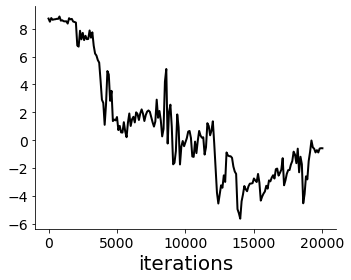

0 -
1 -
2 --
3 --


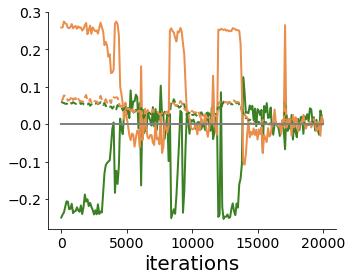

In [4]:
cs = [c_LP, c_LA]
_epi_df = epi_df[epi_df['path'] == path]
plot_opt(_epi_df, max_k=best_k, cs=cs, fontsize=20, figdir=figdir6, save=True)

### EPI samples and simulations

In [5]:
np.random.seed(0)
tf.random.set_seed(0)
z, log_q_z = dist.nf(500)
z = z.numpy()
log_q_z = log_q_z.numpy()
u_t, v_t = SC_sim(*unwrap(z))
u_t, v_t = u_t.numpy(), v_t.numpy()
T_x = np.mean(expit(100.*(v_t[-1,:,:,0,:] - v_t[-1,:,:,3,:])), axis=2)
pP = T_x[:,0]
pA = 1. - T_x[:,1]
#m, b, r, pval, _ = scipy.stats.linregress(T_x[:,0], 1.-T_x[:,1])
#print('pP to pA correlation', r, 'p value', pval)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


### Collect the modes along the ridge

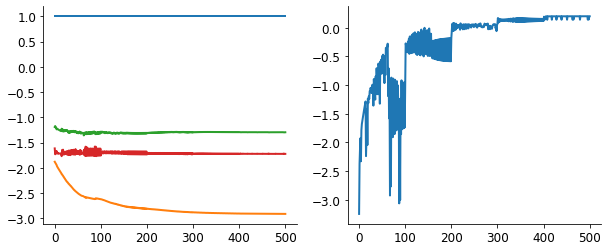

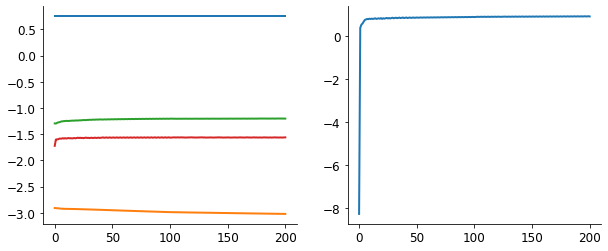

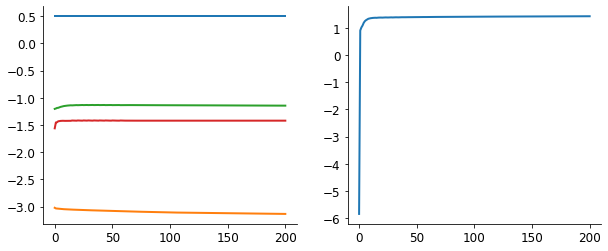

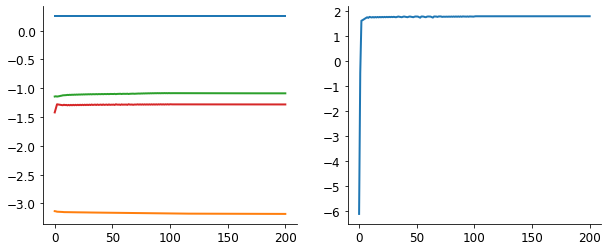

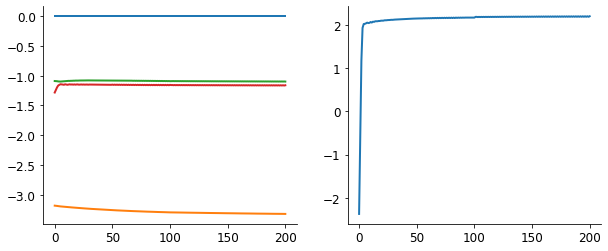

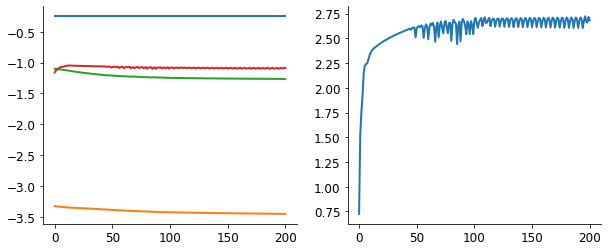

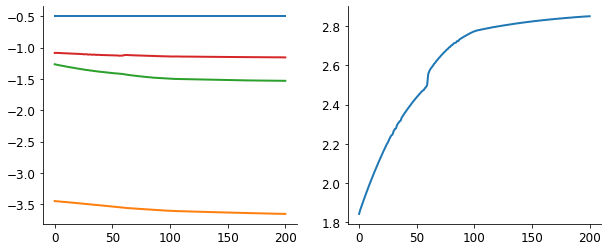

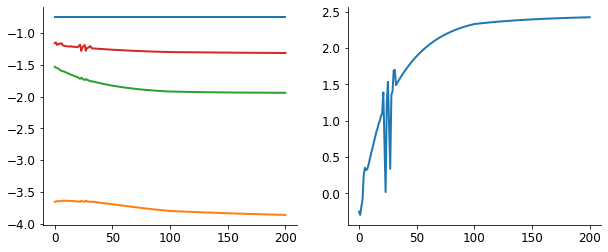

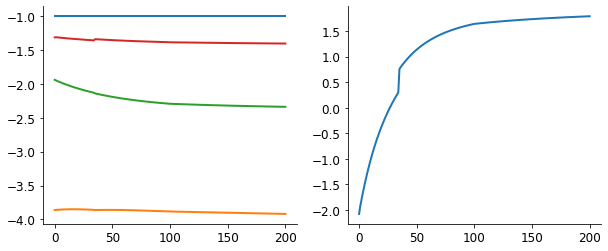

In [42]:
vals = np.linspace(1., -1., 9)
z_init = z[np.argmin(np.abs(z[:,0]-vals[0]))]
z_modes_file = "SC_z_modes.npz"
if os.path.exists(z_modes_file) and False:
    npzfile = np.load(z_modes_file)
    vals, z_stars = npzfile['vals'], npzfile['z_stars']
else:
    num_zs = vals.shape[0]
    num_steps = num_zs*[200]
    num_steps[0] = 500
    lrs = num_zs*[1.e-3]
    lrs[0] = 5.e-3
    lrs[-1] = 5.e-4
    z_init[0] = vals[0]
    z_stars = get_SC_z_mode_path(dist, z_init, 0, vals, lrs, num_steps, decay=0.5, decay_steps=100, do_plot=True)
    np.savez(z_modes_file, vals=vals, z_stars=z_stars)

In [24]:
"""z_modes_file = "SC_z_modes.npz"
if os.path.exists(z_modes_file):
    npzfile = np.load(z_modes_file)
    vals, z_stars_top, z_stars_bot = npzfile['vals'], npzfile['z_stars_top'], npzfile['z_stars_bot']
else:
    vals = np.array([-1.5, -1.4, -1.3, -1.2, -1.1, -1.05])
    num_zs = vals.shape[0]
    num_steps = num_zs*[200]
    lr = 2.5e-4
    z_init_top = np.array([0.5986245, -3.3982022, -1.1453137, -1.5])
    #z_init_top = np.array([-0.02196542, -3.3898032, -1.0818561, -1.1])
    z_stars_top = get_SC_z_mode_path(dist, z_init_top, 3, vals, lr, num_steps, do_plot=True)
    lr = 5e-4
    z_init_bot = np.array([-1.087918 , -4.225775 , -2.4361994, -1.5])
    z_stars_bot = get_SC_z_mode_path(dist, z_init_bot, 3, vals, lr, num_steps, do_plot=True, labels=z_labels)
    np.savez(z_modes_file, vals=vals, z_stars_top=z_stars_top, z_stars_bot=z_stars_bot)"""

'z_modes_file = "SC_z_modes.npz"\nif os.path.exists(z_modes_file):\n    npzfile = np.load(z_modes_file)\n    vals, z_stars_top, z_stars_bot = npzfile[\'vals\'], npzfile[\'z_stars_top\'], npzfile[\'z_stars_bot\']\nelse:\n    vals = np.array([-1.5, -1.4, -1.3, -1.2, -1.1, -1.05])\n    num_zs = vals.shape[0]\n    num_steps = num_zs*[200]\n    lr = 2.5e-4\n    z_init_top = np.array([0.5986245, -3.3982022, -1.1453137, -1.5])\n    #z_init_top = np.array([-0.02196542, -3.3898032, -1.0818561, -1.1])\n    z_stars_top = get_SC_z_mode_path(dist, z_init_top, 3, vals, lr, num_steps, do_plot=True)\n    lr = 5e-4\n    z_init_bot = np.array([-1.087918 , -4.225775 , -2.4361994, -1.5])\n    z_stars_bot = get_SC_z_mode_path(dist, z_init_bot, 3, vals, lr, num_steps, do_plot=True, labels=z_labels)\n    np.savez(z_modes_file, vals=vals, z_stars_top=z_stars_top, z_stars_bot=z_stars_bot)'

### Calculate the sensitivity dimension at each mode

In [43]:
num_zs = z_stars.shape[0]

v1_stars = get_SC_sens_vs(z_stars, dist)
vs_lambda = np.array([eigs_from_z_analytic(v1_stars[i]) for i in range(v1_stars.shape[0])]) / 2.

## Supp Fig SC 4

In [26]:
"""fig, axs = plt.subplots(1, 4, figsize=(14,3))
for i, label in enumerate(z_labels):
    ax = axs[i]
    ax.plot(vals, z_stars[:,i], 'k')
plt.tight_layout()
#plt.savefig(os.path.join(figdir4, "z_trends.png"))
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(14,3))
for i, label in enumerate(z_labels):
    ax = axs[i]
    ax.plot(vals, v1_stars[:,i], 'k')
plt.tight_layout()
#plt.savefig(os.path.join(figdir4, "v_trends.png"))
plt.show()"""

'fig, axs = plt.subplots(1, 4, figsize=(14,3))\nfor i, label in enumerate(z_labels):\n    ax = axs[i]\n    ax.plot(vals, z_stars[:,i], \'k\')\nplt.tight_layout()\n#plt.savefig(os.path.join(figdir4, "z_trends.png"))\nplt.show()\n\nfig, axs = plt.subplots(1, 4, figsize=(14,3))\nfor i, label in enumerate(z_labels):\n    ax = axs[i]\n    ax.plot(vals, v1_stars[:,i], \'k\')\nplt.tight_layout()\n#plt.savefig(os.path.join(figdir4, "v_trends.png"))\nplt.show()'

### Define colors for different regimes

In [27]:
"""red = np.array([216, 0, 0, 256]) / 256.
purple = np.array([102, 0, 204, 256]) / 256.
half = (red + purple) / 2.
cmap_top = matplotlib.colors.LinearSegmentedColormap.from_list("top", [red, half])
cmap_bot = matplotlib.colors.LinearSegmentedColormap.from_list("bot", [purple, half])"""

'red = np.array([216, 0, 0, 256]) / 256.\npurple = np.array([102, 0, 204, 256]) / 256.\nhalf = (red + purple) / 2.\ncmap_top = matplotlib.colors.LinearSegmentedColormap.from_list("top", [red, half])\ncmap_bot = matplotlib.colors.LinearSegmentedColormap.from_list("bot", [purple, half])'

In [44]:
red = np.array([216, 0, 0, 256]) / 256.
purple = np.array([102, 0, 204, 256]) / 256.
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("top", [purple, red])

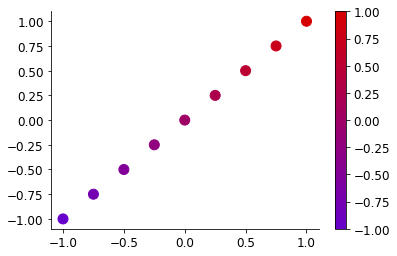

In [45]:
"""# make colorbars for plots
plt.figure()
plt.scatter(vals, vals, c=vals, cmap=cmap)
plt.colorbar(orientation='horizontal', ticks=vals)
plt.show()"""
# make colorbars for plots
plt.figure()
plt.scatter(vals, vals, c=vals, cmap=cmap)
plt.colorbar(ticks=vals)
plt.show()

## Figure 4C

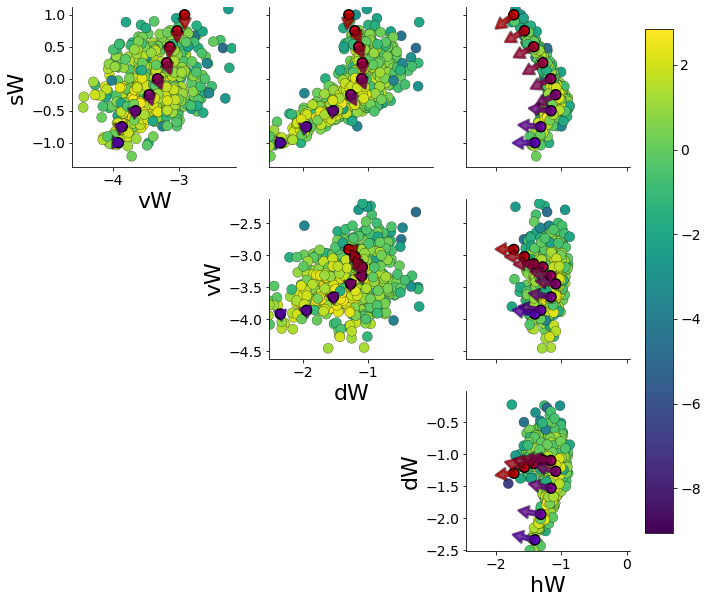

In [46]:
# colors for z_stars
"""vals_for_cmap = vals - np.min(vals)
vals_for_cmap = vals_for_cmap / np.max(vals_for_cmap)
c_stars = np.concatenate((cmap_top(vals_for_cmap),
                          np.flip(cmap_bot(vals_for_cmap), axis=0)),
                         axis=0)"""
vals_for_cmap = vals - np.min(vals)
vals_for_cmap = vals_for_cmap / np.max(vals_for_cmap)
c_stars = cmap(vals_for_cmap)
# bounds for figure, preserve aspect
mean_z = np.mean(z, axis=0)
lim = 1.25
_lb = mean_z - lim
_ub = mean_z + lim
   
alpha = 0.5
v_len = 0.35
c_stars_clear = c_stars.copy()
c_stars_clear[:,3] = alpha
fig, axs = plt.subplots(3,3, figsize=(10,10))
for k, z_star in enumerate(z_stars):
    v = v1_stars[k]
    z1 = z_star
    z2 = z_star + v_len*v
    for i in range(3):
        for j in range(i+1, 4):
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
            arrowprops=dict(headwidth=12, headlength=10, lw=2.5, color=np.array([0., 0., 0., alpha])))
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
             arrowprops=dict(headwidth=10, headlength=9, lw=2, color=c_stars_clear[k]))
fig, axs = pairplot(z, np.arange(4), z_labels, subplots=(fig, axs), 
                    starred=z_stars, c_starred=c_stars, star_marker = 'o',
                    fontsize=22, ticksize=14, s=100, s_star=100,
                    lb=_lb, ub=_ub,
                    c=log_q_z)


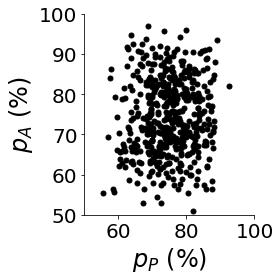

In [47]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.scatter(100*(T_x[:num_plot,0]), 100.*(1-T_x[:num_plot,1]), s=25, c='k')
ax.plot([0,1], [0,1], 'k-')
plt.xlabel(r'$p_P$ (%)', fontsize=24)
plt.ylabel(r'$p_A$ (%)', fontsize=24)
plt.xlim([50, 100])
plt.ylim([50, 100])
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "SC_T_x.pdf"))

## Figure 4D

In [48]:
fac_lim = 0.4
N_fac = 21
facs = np.linspace(-fac_lim, fac_lim, N_fac)

N_sim = 25
pPs, pAs = [], []
for k in range(num_zs):
    print('z_star %d/%d\r' % (k+1, num_zs), end="")
    z_perturb = z_stars[k][None,:] + facs[:,None]*v1_stars[k][None,:]

    _pPs, _pAs = perturbed_acc(z_perturb, SC_sim, N_sim)
    pPs.append(_pPs)
    pAs.append(_pAs)



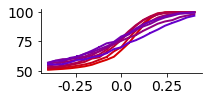

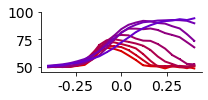

In [49]:
perturbed_acc_plots(facs, pPs, pAs, c_stars, 
                    fontsize=14, label="v1", figdir=figdir)

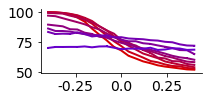

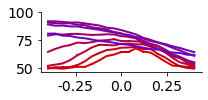

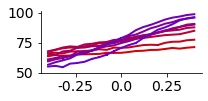

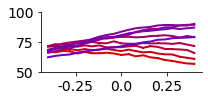

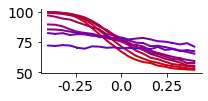

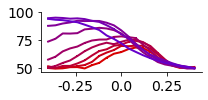

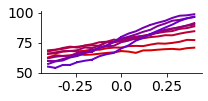

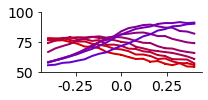

In [50]:
eig_names = ['all', 'side', 'task', 'diag']
for i, eig_name in enumerate(eig_names):
    pPs, pAs = [], []
    for k in range(num_zs):
        print('z_star %d/%d\r' % (k+1, num_zs), end="")
        eigs = np.array([0., 0., 0., 0.])
        eigs[i] = 1.
        vs_eig = z_from_eigs_analytic(eigs)
        vs_eig = vs_eig / np.linalg.norm(vs_eig)
        z_perturb = z_stars[k][None,:] + facs[:,None]*vs_eig[None,:]

        _pPs, _pAs = perturbed_acc(z_perturb, SC_sim, N_sim)
        pPs.append(_pPs)
        pAs.append(_pAs)
    perturbed_acc_plots(facs, pPs, pAs, c_stars, 
                        fontsize=14, label=eig_name, figdir=figdir)
    print("")

## Supp Fig SC 2

In [53]:
z_plots = np.stack((z_stars[1], z_stars[-2]), axis=0)
v_plots = np.stack((v1_stars[0], v1_stars[-1]), axis=0)

50.4, 50.4


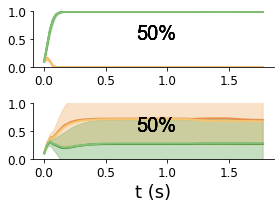

68.4, 73.8


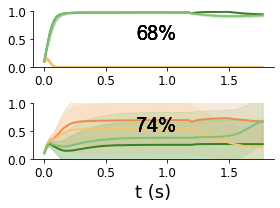

100.0, 48.0


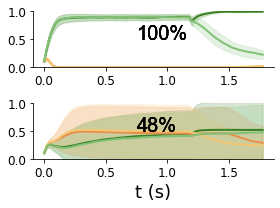

61.7, 50.6


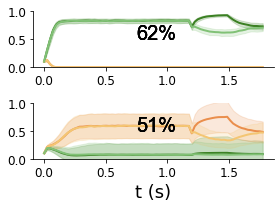

80.5, 81.2


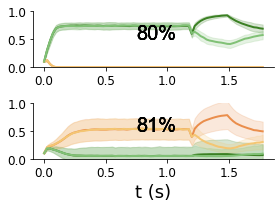

98.9, 89.7


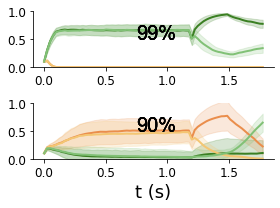

In [54]:

fac_lim = 0.4
facs = np.linspace(-fac_lim, fac_lim, 3)
for i in range(2):
    z_perturb = z_plots[i][None,:] + facs[:,None]*v_plots[i][None,:]
    _, v_t_perturb = SC_sim(*unwrap(z_perturb.astype(np.float32)))
    v_t_perturb = v_t_perturb.numpy()
    fname = os.path.join(figdir2, "z%d_" % (i+1))
    plot_SC_responses(v_t_perturb, fname, figsize=(4,3))

In [55]:
def plot_corr(x, xlabel, y, ylabel, ylim=None, 
                 s=10, num_plot=None, c=None, fontsize=20):
    x_mean, x_std = np.mean(x) ,np.std(x)
    lin_model = scipy.stats.linregress(x, y)
    if c is None:
        c = 'k'
    xticksize = fontsize-6
    yticksize = fontsize-4
    titlesize = fontsize-4
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    x = x[:num_plot]
    y = y[:num_plot]
    
    ax.scatter(x, y, s=s, c=c)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=xticksize)
    plt.setp(ax.get_yticklabels(), fontsize=yticksize)
    
    x1, x2 = x_mean-3.5*x_std, x_mean+3.5*x_std
    ax.set_xlim([x1, x2])
    m, b, r, pval, _ = lin_model
    ax.plot([x1, x2], [b + m*x1, b+m*x2], 'k--')
    if pval < 0.05:
        pval_str = ""
    else:
        pval_str = "(n.s.)"
    metric_str = (r"$\beta$=%.1E, r=%.2f," "\n" "p=%.1E %s") % (m,r,pval,pval_str)
    ax.set_title(metric_str, fontsize=titlesize)
    if ylim is not None:
        ax.set_ylim(ylim)
        
    return fig, ax

# Figure 5

## Figure 5B

In [99]:
strengths = np.linspace(0., 1., 41)
diffs = []
N_opto_test = 500
for strength in strengths:
    sc_acc_diff = SC_acc_diff(strength, 'delay')
    diff = sc_acc_diff(*unwrap(z[:N_opto_test,:])).numpy()
    diff[:,1] = -diff[:,1]
    diffs.append(diff)
diffs = np.array(diffs)

In [100]:
pAerror = np.mean(diffs[:,:,1], axis=1)
strength_exp_ind = np.argmin(np.abs(pAerror - .07))
strength_exp = strengths[strength_exp_ind]
strength_sat = .15
strength_sat_ind = np.where(np.isclose(strengths, strength_sat))[0][0]
print("Closest strength to experimental value:", strength_exp)

Closest strength to experimental value: 0.325


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


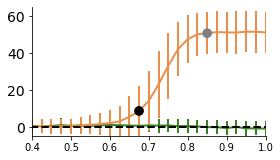

In [103]:
gray = .5*np.ones(3,)
fig, ax = plt.subplots(1,1,figsize=(4,2.33))
diff_mean = np.mean(100.*diffs, axis=1)
diff_std = np.std(100.*diffs, axis=1)
opto_cs = [c_LP, c_LA]
ax.plot([0, 1], [0,0], 'k--')
for j in range(2):
    ax.errorbar(1.-strengths, diff_mean[:,j], diff_std[:,j],
                c=opto_cs[j], zorder=1)
ax.scatter([1.-strength_exp, 1. - strength_sat], 
           [diff_mean[strength_exp_ind, 1], diff_mean[strength_sat_ind, 1]], 
           c=['k', gray], s=75, zorder=2)
fontsize = 12
ticksize = fontsize-2
#ax.set_xlabel('opto strength', fontsize=fontsize)
#ax.set_ylabel('error (%)', fontsize=fontsize)
ax.set_xlim([.4, 1.])
ax.set_ylim([-5, 65])
plt.setp(ax.get_xticklabels(), fontsize=ticksize)
plt.setp(ax.get_yticklabels(), fontsize=(ticksize+4))
plt.tight_layout()
plt.savefig(os.path.join(fig5dir, "opto_strength.pdf"))

## Figure 5CD

In [104]:
import time
def get_local_zs(dist, z_stars, M=1000, n=200):
    C = z_stars.shape[0]
    z_locals = [[] for i in range(C)]
    while True:
        z = dist.sample(M)
        diffs = np.sum(np.square(z[:,None,:] - z_stars[None,:,:]), axis=2)
        c = np.argmin(diffs, axis=1)
        for i in range(C):
            if z_locals[i]==[]:
                if np.sum(c==i) > 0:
                    z_locals[i] = z[c==i,:]
            else:
                if z_locals[i].shape[0] < n:
                    z_locals[i] = np.concatenate((z_locals[i], z[c==i,:]), axis=0)
        if np.all([z_local.shape[0] >= n for z_local in z_locals]):
            break
            
    for i in range(C):
        z_locals[i] = z_locals[i][:n,:]
        
    return z_locals
t1 = time.time()
z_locals = get_local_zs(dist, z_stars, M = 1000, n=500)
t2 = time.time()
print(t2 - t1)


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


2.670154094696045


In [106]:
2.67/500.

0.00534

In [105]:
import time
def get_local_zs_rand(z_stars, M=1000, n=200):
    C = z_stars.shape[0]
    z_locals = [[] for i in range(C)]
    while True:
        z = np.random.uniform(-5., 5., (M,4)).astype(np.float32)
        p = model.eps(z)[:,:2].numpy()
        p[:,1] = 1.-p[:,1]
        pP_accept = np.logical_and(.6 <= p[:,0], p[:,0] <= .9)
        pA_accept = np.logical_and(.6 <= p[:,1], p[:,1] <= .9)
        z_accept = np.logical_and(pP_accept, pA_accept)
        z = z[z_accept,:]
        if z.shape[0] == 0:
            print('Nope')
            print([z_local.shape[0] if not z_local == [] else '' for z_local in z_locals])
            continue
        else:
            print(z.shape[0])
            print('found one!')
            print([z_local.shape[0] if not z_local == [] else '' for z_local in z_locals])
        diffs = np.sum(np.square(z[:,None,:] - z_stars[None,:,:]), axis=2)
        c = np.argmin(diffs, axis=1)
        for i in range(C):
            if z_locals[i]==[]:
                if np.sum(c==i) > 0:
                    z_locals[i] = z[c==i,:]
            else:
                if z_locals[i].shape[0] < n:
                    z_locals[i] = np.concatenate((z_locals[i], z[c==i,:]), axis=0)
        
        if np.all([not (z_local == []) for z_local in z_locals]):
            if np.all([z_local.shape[0] >= n for z_local in z_locals]):
                break
            
    for i in range(C):
        z_locals[i] = z_locals[i][:n,:]
        
    return z_locals

t1 = time.time()
z_locals_rand = get_local_zs_rand(z_stars, M = 1000, n=5)
t2 = time.time()
print(t2 - t1)

Nope
['', '', '', '', '', '', '', '', '']
1
found one!
['', '', '', '', '', '', '', '', '']


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1
found one!
['', '', '', '', '', '', '', '', 1]


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


2
found one!
['', '', 1, '', '', '', '', '', 1]
Nope
[1, '', 1, '', '', '', 1, '', 1]


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


Nope
[1, '', 1, '', '', '', 1, '', 1]
1
found one!
[1, '', 1, '', '', '', 1, '', 1]
1
found one!
[1, '', 1, '', 1, '', 1, '', 1]
Nope
[1, '', 2, '', 1, '', 1, '', 1]
Nope
[1, '', 2, '', 1, '', 1, '', 1]
Nope
[1, '', 2, '', 1, '', 1, '', 1]
1
found one!
[1, '', 2, '', 1, '', 1, '', 1]
Nope
[1, '', 2, '', 1, '', 1, '', 2]
Nope
[1, '', 2, '', 1, '', 1, '', 2]
Nope
[1, '', 2, '', 1, '', 1, '', 2]
Nope
[1, '', 2, '', 1, '', 1, '', 2]
2
found one!
[1, '', 2, '', 1, '', 1, '', 2]
Nope
[1, '', 3, 1, 1, '', 1, '', 2]
Nope
[1, '', 3, 1, 1, '', 1, '', 2]
Nope
[1, '', 3, 1, 1, '', 1, '', 2]
Nope
[1, '', 3, 1, 1, '', 1, '', 2]
Nope
[1, '', 3, 1, 1, '', 1, '', 2]
Nope
[1, '', 3, 1, 1, '', 1, '', 2]
1
found one!
[1, '', 3, 1, 1, '', 1, '', 2]
Nope
[1, '', 3, 1, 1, '', 1, '', 3]
1
found one!
[1, '', 3, 1, 1, '', 1, '', 3]
Nope
[1, '', 3, 1, 1, '', 1, 1, 3]
Nope
[1, '', 3, 1, 1, '', 1, 1, 3]
1
found one!
[1, '', 3, 1, 1, '', 1, 1, 3]
Nope
[1, '', 4, 1, 1, '', 1, 1, 3]
Nope
[1, '', 4, 1, 1, '', 1, 1, 3]

2
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
Nope
[5, 4, 5, 5, 5, 6, 5, 5, 5]
1
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
1
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
Nope
[5, 4, 5, 5, 5, 6, 5, 5, 5]
1
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
1
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
Nope
[5, 4, 5, 5, 5, 6, 5, 5, 5]
Nope
[5, 4, 5, 5, 5, 6, 5, 5, 5]
1
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
Nope
[5, 4, 5, 5, 5, 6, 5, 5, 5]
1
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
2
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
Nope
[5, 4, 5, 5, 5, 6, 5, 5, 5]
2
found one!
[5, 4, 5, 5, 5, 6, 5, 5, 5]
575.124724149704


In [118]:
brute_time = 100 * (t2 - t1)
print(brute_time / (100.*60.))
print(brute_time / (500.*60.))
print(brute_time / (500.))
print(brute_time / (3600.))

9.585412069161732
1.9170824138323466
115.0249448299408
15.975686781936222


In [112]:
epi_time = 2.670154094696045
brute_time = 57512.4724149704
epi_time_per_sample = epi_time / 500.
brute_time_per_sample = brute_time / 500.
print(epi_time_per_sample)
print(brute_time_per_sample)
print(brute_time_per_sample / epi_time_per_sample)

0.00534030818939209
115.0249448299408
21539.008752046306


In [61]:
def get_corr(x, y):
    x_mean, x_std = np.mean(x) ,np.std(x)
    lin_model = scipy.stats.linregress(x, pAerrors[i])
    m, b, r, pval, _ = lin_model
    return r
    


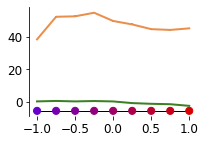

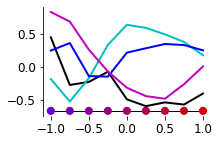

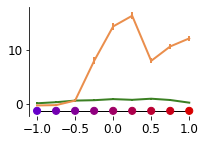

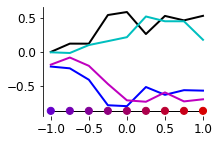

In [98]:
strengths = [strength_sat, strength_exp]
opto_data = []
val_ticks = [-1, -.5, 0, .5, 1.]
for strength in strengths:
    sc_acc_opto = SC_acc_opto(strength, 'delay')

    pPs = []
    pAs = []
    pPoptos = []
    pAoptos = []
    pPerrors = []
    pAerrors = []
    C = len(z_locals)
    for z_local in z_locals:
        acc_opto = sc_acc_opto(*unwrap(z_local)).numpy()
        pPs.append(100.*acc_opto[:,0])
        pAs.append(100.*(1. - acc_opto[:,1]))
        pPoptos.append(100.*acc_opto[:,2])
        pAoptos.append(100.*(1. - acc_opto[:,3]))
        pPerrors.append(pPs[-1] - pPoptos[-1])
        pAerrors.append(pAs[-1] - pAoptos[-1])
        
        _pPerr = np.array(pPerrors)
        _pAerr = np.array(pAerrors)
        pPerr_mean = np.mean(_pPerr, axis=1)
        pAerr_mean = np.mean(_pAerr, axis=1)
        pPerr_std = np.std(_pPerr, axis=1)/np.sqrt(N_opto_test)
        pAerr_std = np.std(_pAerr, axis=1)/np.sqrt(N_opto_test)
        
    fig, ax = plt.subplots(1,1,figsize=(3,2))
    ax.errorbar(vals, pPerr_mean, pPerr_std, c=c_LP)
    ax.errorbar(vals, pAerr_mean, pAerr_std, c=c_LA)
    ax.set_xticks(val_ticks)
    ylim = ax.get_ylim()
    ax.plot(vals, np.array(num_zs*[ylim[0]]), 'k-', lw=1, zorder=1)
    ax.scatter(vals, np.array(num_zs*[ylim[0]]), c=c_stars, zorder=2, s=50)
    ax.spines['bottom'].set_visible(False)
    #ax.set_xticklabels([]);

    eig_corrs = []
    for k in range(4):
        _eig_corrs = []
        for i, z_local in enumerate(z_locals):
            eigs = np.array([eigs_from_z_analytic(_z_local) for _z_local in z_local])
            x = eigs[:, k]
            r = get_corr(x, pAerrors[i])
            _eig_corrs.append(r)
        eig_corrs.append(np.array(_eig_corrs))
    eig_corrs = np.array(eig_corrs)


    fig, ax = plt.subplots(1,1,figsize=(3,2))
    cs = ['k', 'c', 'b', 'm']
    for k in range(4):
        ax.plot(vals, eig_corrs[k], label=r'$\lambda_{%s}$' % eig_names[k], c=cs[k])
    ax.set_xticks(val_ticks)
    ylim = ax.get_ylim()
    ax.plot(vals, np.array(num_zs*[ylim[0]]), 'k-', lw=1, zorder=1)
    ax.scatter(vals, np.array(num_zs*[ylim[0]]), c=c_stars, zorder=2, s=50)
    ax.spines['bottom'].set_visible(False)
    #ax.set_xticklabels([]);
    
    opto_dict = {'pPs':pPs,
                 'pAs':pAs,
                 'pPoptos':pPoptos,
                 'pAoptos':pAoptos,
                 'pPerrors':pPerrors,
                 'pAerrors':pAerrors,
                 'eig_corrs':eig_corrs,
                }
    opto_data.append(opto_dict)

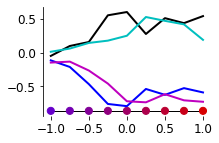

In [97]:
fig, ax = plt.subplots(1,1,figsize=(3,2))
cs = ['k', 'c', 'b', 'm']
for k in range(4):
    ax.plot(vals, eig_corrs[k], label=r'$\lambda_{%s}$' % eig_names[k], c=cs[k])
ax.set_xticks(val_ticks)
ylim = ax.get_ylim()
ax.plot(vals, np.array(num_zs*[ylim[0]]), 'k-', lw=1, zorder=1)
ax.scatter(vals, np.array(num_zs*[ylim[0]]), c=c_stars, zorder=2, s=50)
ax.spines['bottom'].set_visible(False)
plt.show()

## Figure 5E

76.1, 23.0


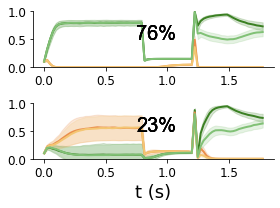

82.5, 80.9


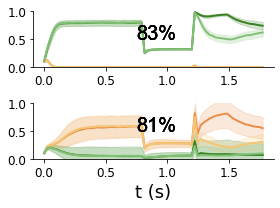

In [63]:
strengths = [strength_sat, strength_exp]
labels = ['sat', 'exp']
for strength, label in zip(strengths, labels):
    sc_sim_opto = SC_sim_opto(strength, 'delay')
    z_mode = z[[np.argmax(log_q_z)],:]
    _, v_t_stars = sc_sim_opto(*unwrap(z_mode))
    v_t_stars = v_t_stars.numpy()[:,:,2:,:,:]

    fname = os.path.join(fig5dir, "opto_%s" % label)
    plot_SC_responses(v_t_stars, fname, figsize=(4,3))


## Figure 5F

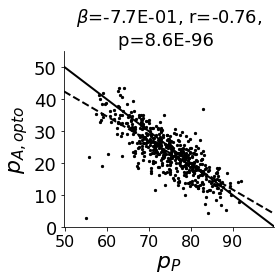

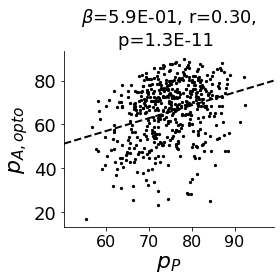

In [64]:
for strength, label in zip(strengths, labels):
    sc_acc_opto = SC_acc_opto(strength, 'delay')
    acc_opto = sc_acc_opto(*unwrap(z)).numpy()
    pPs = 100.*acc_opto[:,0]
    pAoptos = 100.*(1. - acc_opto[:,3])

    fig, ax = plot_corr(pPs, r'$p_P$', pAoptos, r'$p_{A,opto}$',
                    s=5, fontsize=22)
    if label == 'sat':
        plt.plot([0, 100], [100, 0], 'k')
        plt.ylim([0,55])
    plt.tight_layout()
    plt.savefig(os.path.join(fig5dir, "opto_%s_corrs.pdf" % label))

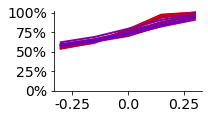

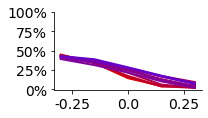

75.9, 25.4


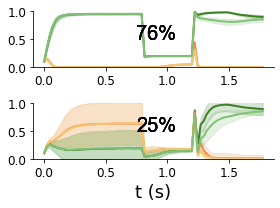

73.3, 29.9


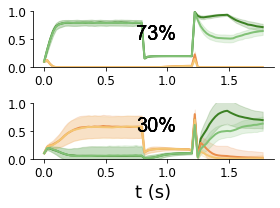

In [339]:
_sc_sim_opto = SC_sim_opto(strength_sat, 'delay')
def sc_sim_opto(w,x,y,z): 
    u, v = _sc_sim_opto(w,x,y,z)
    return u[:,:,2], v[:,:,2:]

pPs_optos, pAs_optos = [], []
for k in range(num_zs):
    print('z_star %d/%d\r' % (k+1, num_zs), end="")
    z_perturb = z_stars[k][None,:] + facs[:,None]*vs[k][None,:]
    pPs_opto, pAs_opto = perturbed_acc(z_perturb, sc_sim_opto, N_sim)
    pPs_optos.append(pPs_opto)
    pAs_optos.append(pAs_opto)

perturbed_acc_plots(facs, pPs_optos, pAs_optos, c_stars, 
                    fontsize=14, label="v1_opto", figdir=fig5dir)


In [192]:
"""mean_diff = np.mean(100.*diffs, axis=0)
std_diff = np.std(100.*diffs, axis=0)
fig, ax = plt.subplots(1,1,figsize=(2.5,3))
_cs = [c_LP, c_LA]
plt.scatter([0,1], mean_diff, color=_cs, s=40)
for i in range(2):
    plt.plot([i,i], [mean_diff[i]-std_diff[i], mean_diff[i]+std_diff[i]], '-', c=_cs[i])
plt.xlim([-.5, 1.5])
plt.ylim([-7, 12])
plt.plot([-1, 2], [0, 0], 'k-')
ax.set_xticks([0,1])
ax.set_xticklabels(['', ''], fontsize=18)
ax.set_yticks([-5, 0, 5, 10])
ax.set_yticklabels([-5, 0, 5, 10], fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(figdir, "delay_error.pdf"), transparent=True)
for i in range(2):
    t, p = scipy.stats.ttest_1samp(diffs[:,i], 0.)
    print(i,t,p)
    
print('two-tailed')
scipy.stats.ttest_rel(diffs[:,0], diffs[:,1])"""

'mean_diff = np.mean(100.*diffs, axis=0)\nstd_diff = np.std(100.*diffs, axis=0)\nfig, ax = plt.subplots(1,1,figsize=(2.5,3))\n_cs = [c_LP, c_LA]\nplt.scatter([0,1], mean_diff, color=_cs, s=40)\nfor i in range(2):\n    plt.plot([i,i], [mean_diff[i]-std_diff[i], mean_diff[i]+std_diff[i]], \'-\', c=_cs[i])\nplt.xlim([-.5, 1.5])\nplt.ylim([-7, 12])\nplt.plot([-1, 2], [0, 0], \'k-\')\nax.set_xticks([0,1])\nax.set_xticklabels([\'\', \'\'], fontsize=18)\nax.set_yticks([-5, 0, 5, 10])\nax.set_yticklabels([-5, 0, 5, 10], fontsize=18)\n\nplt.tight_layout()\nplt.savefig(os.path.join(figdir, "delay_error.pdf"), transparent=True)\nfor i in range(2):\n    t, p = scipy.stats.ttest_1samp(diffs[:,i], 0.)\n    print(i,t,p)\n    \nprint(\'two-tailed\')\nscipy.stats.ttest_rel(diffs[:,0], diffs[:,1])'